In [1]:
import numpy as np
import random
import math
import time
from tqdm import tqdm
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt
from numba import jit

# V1

In [5]:
class Ising2D:
    def __init__(self,N):
        """
        Initialize the Ising2D class.

        Parameters:
        - N (int): The size of the 2D lattice.

        Returns:
        None
        """
        self.N = N
        self.Ns = N*N
        self.spin = np.zeros((N,N),dtype=np.uint8)
        self.nbits = 8
        self.Nspin = self.Ns*self.nbits
                
    def temperature(self,T):
        """
        Set the temperature for the Ising model.

        Parameters:
        - T (float): The temperature value.

        Returns:
        None
        """
        beta = 1.0/T
        p0 = math.exp(-8.0*beta)
        p1 = (math.exp(-4.0*beta)-p0)/(1.0-p0)
        self.deuxp0 = p0*2.0
        self.deuxp1 = p1*2.0
     
    def voisin(self,i,j):
        """
        Get the value of the neighboring spin at position (i, j).

        Parameters:
        - i (int): The x-coordinate of the spin.
        - j (int): The y-coordinate of the spin.

        Returns:
        int: The value of the neighboring spin.
        """
        ii = i
        if ii<0:
            ii=self.N-1
        elif ii>=self.N:
            ii=0
        jj = j
        if jj<0:
            jj=self.N-1
        elif jj>=self.N:
            jj=0
        return self.spin[jj][ii]
        
                
    def metropolis(self):
        """
        Perform a Metropolis update on a randomly chosen spin.

        Parameters:
        None

        Returns:
        None
        """
        i = random.randint(0,self.N-1)
        j = random.randint(0,self.N-1)
        s = self.spin[j][i]
        a1 = s^self.voisin(i-1,j)
        a2 = s^self.voisin(i+1,j)
        a3 = s^self.voisin(i,j-1)
        a4 = s^self.voisin(i,j+1)
        R1 = a1|a2|a3|a4
        R2 = ((a1|a2)&(a3|a4))|((a1&a2)|(a3&a4))
        if random.random() < self.deuxp0:
            r0 = random.getrandbits(self.nbits)
        else:
            r0 = 0
        if random.random() < self.deuxp1:
            r1 = random.getrandbits(self.nbits)
        else:
            r1 = 0
        self.spin[j][i] = s^(R2|(R1&r1)|r0)    
                
    def moment(self):
        """
        Calculate the magnetization of the lattice.

        Parameters:
        None

        Returns:
        float: The magnetization value.
        """
        m = 0.0
        for i in range(self.N):
            for j in range(self.N):
                s = self.spin[j][i]
                for b in range(self.nbits):
                    m += 2*(s&1)-1
                    s = s >> 1
        return -m*1.0/self.Nspin
                
    def boucle(self,n):
        """
        Perform a loop of Metropolis updates and calculate the magnetization.

        Parameters:
        - n (int): The number of iterations.

        Returns:
        tuple: A tuple containing the magnetization array, the mean magnetization, and the standard deviation of the magnetization.
        """
        m = np.zeros(n,dtype=np.float32)
        for k in range(n):
            for l in range(self.Ns):
                self.metropolis()
            m[k] = self.moment()
        return (m,np.mean(m),np.std(m))
                 
    def couche(self,b):
        """
        Extract a layer of spins from the lattice.

        Parameters:
        - b (int): The bit position of the layer to extract.

        Returns:
        np.ndarray: The extracted layer of spins.
        """
        mask = np.ones((self.N,self.N),dtype=np.uint8)*2**b
        return np.bitwise_and(self.spin,mask)

Matrice 1600 * 1000 pour total_plot

In [ ]:
start = time.time()

def main_compute(T) :
    N = 40
    n = 1000
    ising = Ising2D(N)
    ising.temperature(T)
    ising.boucle(n)
    couche = ising.couche(0)
    return couche.reshape(N*N)

T = np.linspace(0.0,4.0,1000)

spins = Parallel(n_jobs=-1)(delayed(main_compute)(T[i]) for i in tqdm(range(len(T))))
pickle.dump(spins, open('spins.pkl', 'wb'))


end = time.time()
print(end - start)

Grosse matrice

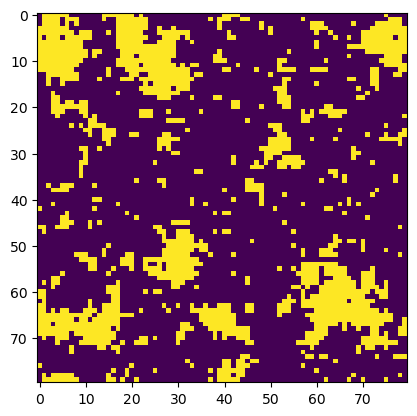

53.78352093696594


In [42]:
start = time.time()

ising = Ising2D(80)
ising.temperature(2.3)
ising.boucle(1000)
couche = ising.couche(0)
plt.imshow(couche)
plt.show()

end = time.time()
print(end - start)

# V2

In [2]:
@jit(nopython=True)
def inital_state(L):
  """
  """
  random = np.empty((L,L))
  for i in range(L):
    for j in range(L):
        random[i,j] = np.random.random()
  state = 2*random-1
  return state

@jit(nopython=True)
def calc_energy(state,H=0):
  """
  """
  energy = 0
  L = len(state)

  for i in range(L):
    for j in range(L):
      S = state[i,j]
      nb = state[(i+1)%L, j] + state[i,(j+1)%L] + state[(i-1)%L, j] + state[i,(j-1)%L]
      energy = energy + -1*(nb*S + H*S)
      #print("S = ", S, "| nb = ", nb,"| energy = ", energy)
  return energy

@jit(nopython=True)
def calc_mag(state):
  """
  """
  mag = np.sum(state)
  #print("mag = ", mag)
  return mag

@jit(nopython=True)
def mc_move(state,T):
  """
  """
  L = len(state)

  a = np.random.randint(0,L)
  b = np.random.randint(0,L)

  #print(state)
  #print("a = ", a, "| b = ", b)

  s = state[a,b]
  nb = state[(a+1)%L, b] + state[a,(b+1)%L] + state[(a-1)%L, b] + state[a,(b-1)%L]
  dE = 2*s*nb
  dS = 0
  #print("s = ", s, "| nb = ", nb, "| dE = ", dE)

  if dE <= 0:
    s = s*-1
    dS = 2*s

  elif np.random.rand() < np.exp(-dE/T):
    s = s*-1
    dS = 2*s
  
  else:
    dE = 0

  state[a,b] = s

  return state,dE,dS

@jit(nopython=True)
def two_dim_ising(L,temp,num_steps):
  """
  """
  N = L**2
  state = inital_state(L)

  #plt.matshow(state,cmap="Greys")
  #plt.show()

  E = calc_energy(state)
  S = calc_mag(state)

  dE = 0
  dS = 0

  E_avg = np.zeros(num_steps)
  S_avg = np.zeros(num_steps)

  E_avg[0] = E
  S_avg[0] = S

  #print("E0 = ", E, "S0 = ", S)

  for i in range(1,num_steps):
    state, dE, dS = mc_move(state,temp)

    #print("dE = ", dE, "dS = ", dS)

    E = E + dE
    S = S + dS

    #print("E = ", E, "S = ", S)

    E_avg[i] = E_avg[i-1] + (E-E_avg[i-1])/(i+1)
    S_avg[i] = S_avg[i-1] + (S-S_avg[i-1])/(i+1)

  S_avg = np.abs(S_avg)/N
  #S_avg = S_avg/N
  E_avg = E_avg/N

  return state,E_avg,S_avg

@jit(nopython=True)
def two_dim_ising_move(L,temp,num_steps):
  """
  """
  state = inital_state(L)
  for i in range(num_steps):
    state, dE, dS = mc_move(state,temp)
  return state

@jit(nopython=True)
def two_dim_ising_state(state,temp,num_steps):
  """
  """
  N = np.size(state)

  #plt.matshow(state,cmap="Greys")
  #plt.show()

  E = calc_energy(state)
  S = calc_mag(state)

  dE = 0
  dS = 0

  E_avg = np.zeros(num_steps)
  S_avg = np.zeros(num_steps)

  E_avg[0] = E
  S_avg[0] = S

  #print("E0 = ", E, "S0 = ", S)

  for i in range(1,num_steps):
    state, dE, dS = mc_move(state,temp)

    #print("dE = ", dE, "dS = ", dS)

    E = E + dE
    S = S + dS

    #print("E = ", E, "S = ", S)

    E_avg[i] = E_avg[i-1] + (E-E_avg[i-1])/(i+1)
    S_avg[i] = S_avg[i-1] + (S-S_avg[i-1])/(i+1)

  S_avg = np.abs(S_avg)/N
  #S_avg = S_avg/N
  E_avg = E_avg/N

  return state,E_avg,S_avg

Matrice 1600 * 1000 pour total_plot

100%|██████████| 1000/1000 [00:08<00:00, 122.34it/s]


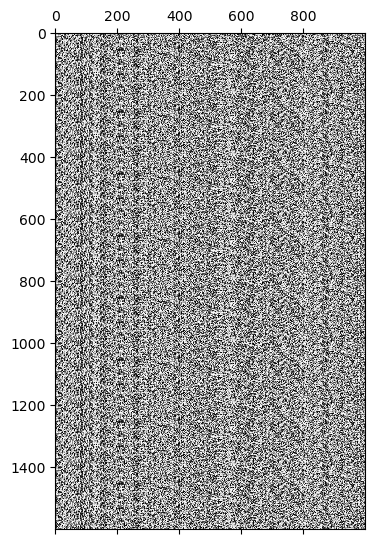

In [14]:
start = time.time()
T = np.linspace(0.1,4.0,1000)
spins = np.empty((len(T),40,40))
for i in tqdm(range(len(T))):
    spins[i,:,:] = two_dim_ising_move(40,T[i],100000)[0]

end = time.time()

spins = spins.reshape(len(T),40*40).T

plt.matshow(spins,cmap="Greys")
plt.show()

Grosse matrice

(-0.5, 599.5, 599.5, -0.5)

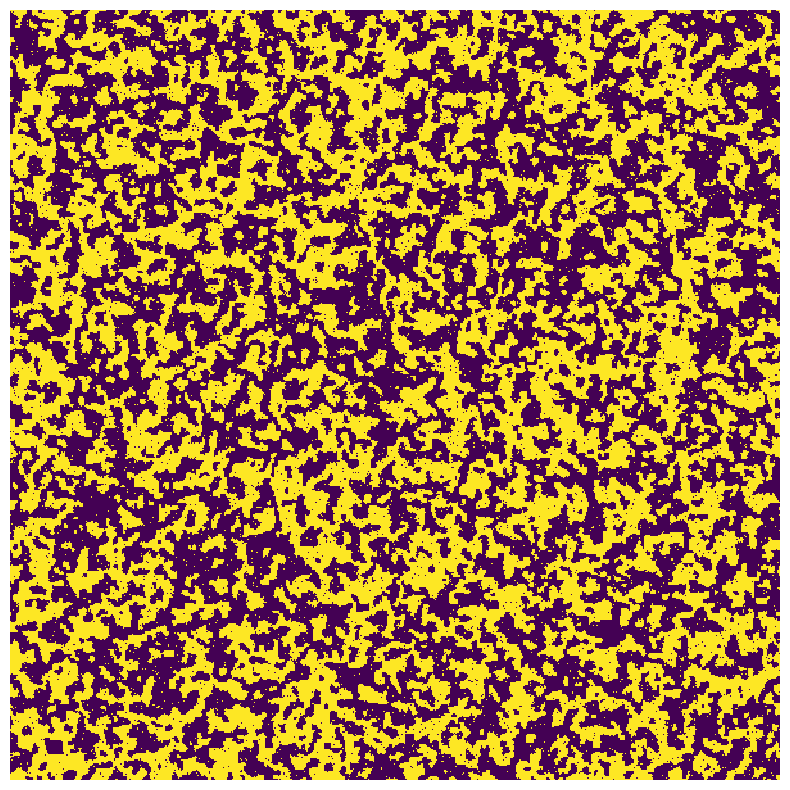

In [3]:
start = time.time()
state = two_dim_ising(600,0.1,1000000000)[0]
state[state > 0] = 1
state[state <= 0] = 0
end = time.time()

plt.figure(figsize=(10,10))
plt.imshow(state, interpolation='nearest')
plt.axis('off')